In [3]:
import json
import numpy as np
import pandas as pd

from collections import Counter

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

from sklearn.preprocessing import MultiLabelBinarizer

from tqdm import tqdm

In [2]:
data_path = "arxiv-metadata-oai-snapshot.json"
data = []

with open(data_path) as f:
    for line in tqdm(f):
        data.append(json.loads(line))

df = pd.DataFrame(data)

2908095it [01:24, 34261.75it/s]


In [5]:
def multilabel_sample(df, n):
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(df["categories"].str.split())

    msss = MultilabelStratifiedShuffleSplit(
        n_splits=1,
        train_size=n,
        test_size=len(df) - n,
        random_state=42
    )

    for idx, _ in msss.split(df, Y):
        return df.iloc[idx]


s1 = multilabel_sample(df, 200000)
s2 = multilabel_sample(df, 200000)

In [6]:
def category_distribution(df):
    c = Counter()
    for cats in df["categories"].str.split():
        c.update(cats)

    total = sum(c.values())

    return {k: v / total for k, v in c.items()}


dist_full = category_distribution(df)
dist_s1 = category_distribution(s1)
dist_s2 = category_distribution(s2)

diff = {
    k: abs(dist_s1.get(k, 0) - dist_s2.get(k, 0))
    for k in dist_full
}

max(diff.values()), sum(diff.values()) / len(diff)

(0.0, 0.0)

In [10]:
df["category_list"] = df["categories"].str.split()

mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(df["category_list"])

msss = MultilabelStratifiedShuffleSplit(
    n_splits=1,
    train_size=200000,
    test_size=len(df) - 200000,
    random_state=42
)

for train_idx, _ in msss.split(df, Y):
    df_sample = df.iloc[train_idx].copy()

In [11]:
df_sample.to_pickle("arxiv_sample_200k.pkl")

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline
sns.set_style("whitegrid")

In [4]:
df_sample = pd.read_pickle("arxiv_sample_200k.pkl")

df = df_sample.copy()

print("Shape:", df.shape)
df.head(2)

Shape: (199749, 15)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,category_list
8,0704.0009,Paul Harvey,"Paul Harvey, Bruno Merin, Tracy L. Huard, Luis...","The Spitzer c2d Survey of Large, Nearby, Inste...",None,"Astrophys.J.663:1149-1173,2007",10.1086/518646,None,astro-ph,None,We discuss the results from the combined IRA...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2010-03-18,"[[Harvey, Paul, ], [Merin, Bruno, ], [Huard, T...",[astro-ph]
16,0704.0017,Nceba Mhlahlo,"Nceba Mhlahlo, David H. Buckley, Vikram S. Dhi...",Spectroscopic Observations of the Intermediate...,"10 pages, 11 figures (figures 3, 4, 7 and 8 at...","Mon.Not.Roy.Astron.Soc.378:211-220,2007",10.1111/j.1365-2966.2007.11762.x,None,astro-ph,None,Results from spectroscopic observations of t...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2009-06-23,"[[Mhlahlo, Nceba, ], [Buckley, David H., ], [D...",[astro-ph]


In [5]:
df["id"].is_unique

True

In [6]:
df.isna().mean().sort_values(ascending=False).head(10)

report-no      0.935018
journal-ref    0.683643
doi            0.560819
comments       0.270374
license        0.154779
submitter      0.005447
id             0.000000
title          0.000000
authors        0.000000
categories     0.000000
dtype: float64

In [7]:
df["category_list"] = df["categories"].str.split()
df["author_list"] = df["authors"].str.split(", ")

In [9]:
df["year"] = df["versions"].apply(
    lambda v: pd.to_datetime(v[0]["created"]).year
)

In [10]:
df["year"].describe()

count    199749.000000
mean       2016.151060
std           7.732047
min        1989.000000
25%        2012.000000
50%        2018.000000
75%        2022.000000
max        2025.000000
Name: year, dtype: float64

In [11]:
df["abstract_length"] = df["abstract"].str.len()

df["abstract_length"].describe()

count    199749.000000
mean        987.565019
std         431.884863
min          25.000000
25%         652.000000
50%         965.000000
75%        1302.000000
max        3874.000000
Name: abstract_length, dtype: float64

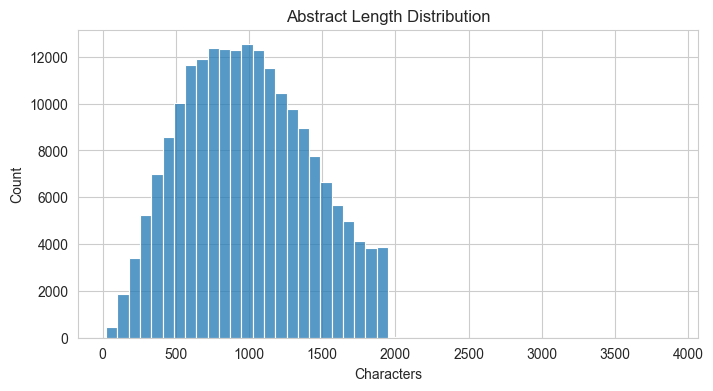

In [12]:
plt.figure(figsize=(8,4))
sns.histplot(df["abstract_length"], bins=50)
plt.title("Abstract Length Distribution")
plt.xlabel("Characters")
plt.show()

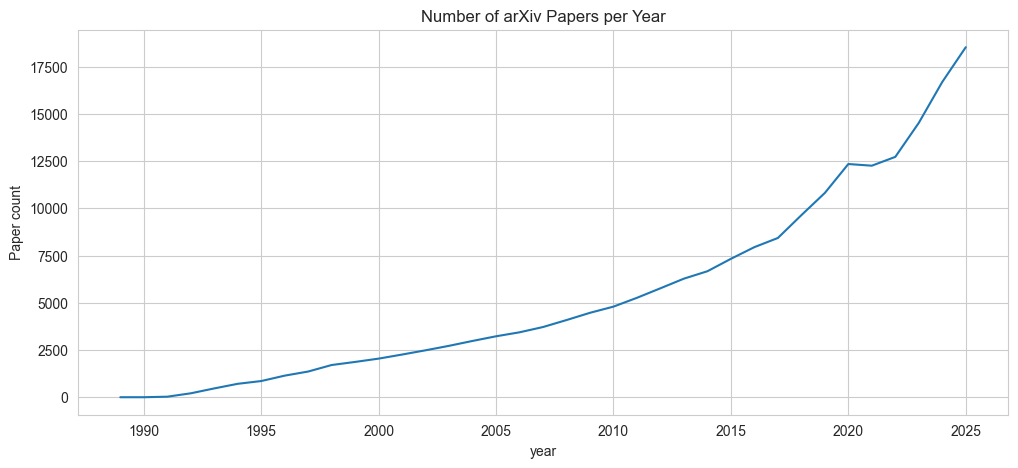

In [13]:
papers_per_year = df.groupby("year").size()

plt.figure(figsize=(12,5))
papers_per_year.plot()
plt.title("Number of arXiv Papers per Year")
plt.ylabel("Paper count")
plt.show()

In [14]:
cat_counter = Counter()

for cats in df["category_list"]:
    cat_counter.update(cats)

cat_df = pd.DataFrame(
    cat_counter.most_common(20),
    columns=["category", "count"]
)

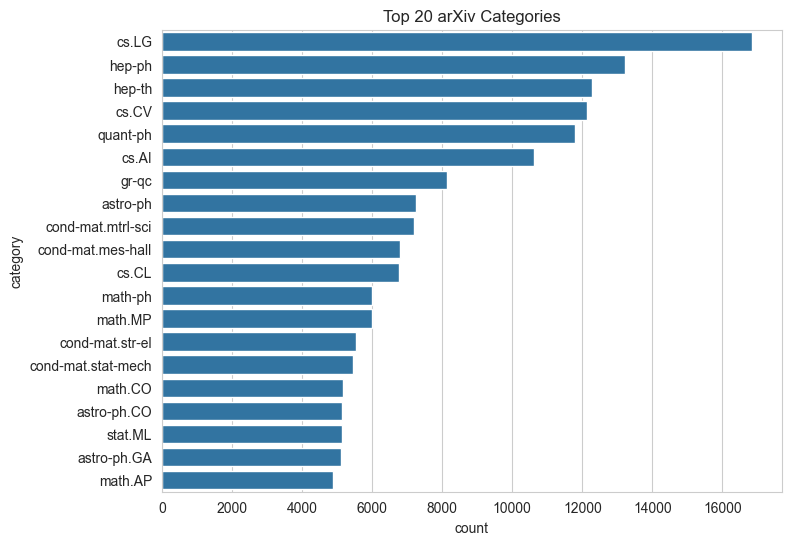

In [15]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=cat_df,
    x="count",
    y="category"
)
plt.title("Top 20 arXiv Categories")
plt.show()

In [16]:
year_cat = []

for _, row in df.iterrows():
    for cat in row["category_list"]:
        year_cat.append((row["year"], cat))

year_cat_df = pd.DataFrame(year_cat, columns=["year", "category"])

In [17]:
top_categories = cat_df["category"].head(8)

trend_df = (
    year_cat_df[year_cat_df["category"].isin(top_categories)]
    .groupby(["year", "category"])
    .size()
    .unstack(fill_value=0)
)

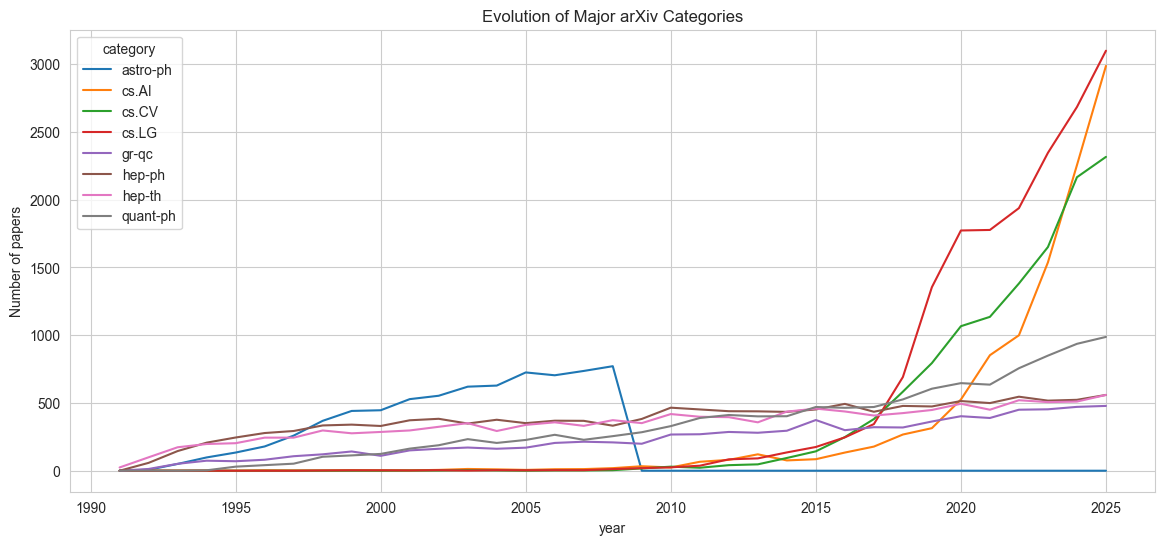

In [18]:
trend_df.plot(figsize=(14,6))
plt.title("Evolution of Major arXiv Categories")
plt.ylabel("Number of papers")
plt.show()

In [19]:
author_counter = Counter()

for authors in df["author_list"]:
    author_counter.update(authors)

author_df = pd.DataFrame(
    author_counter.most_common(20),
    columns=["author", "paper_count"]
)

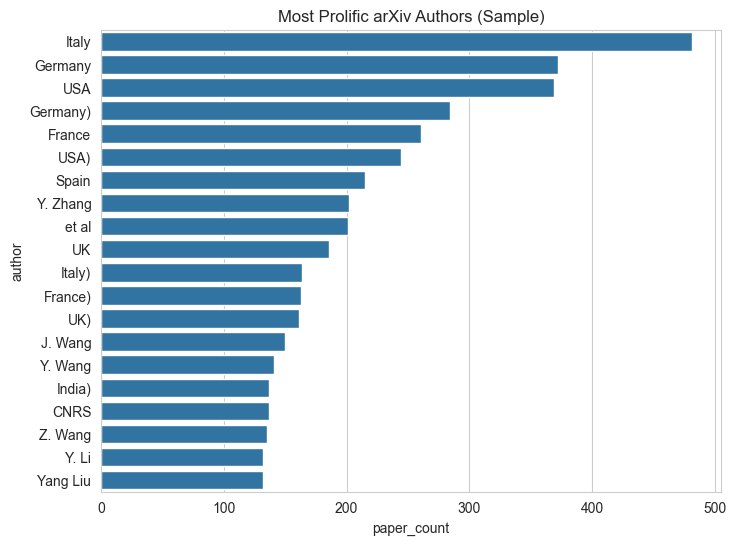

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(
    data=author_df,
    x="paper_count",
    y="author"
)
plt.title("Most Prolific arXiv Authors (Sample)")
plt.show()

In [21]:
df["n_authors"] = df["author_list"].apply(len)

df["n_authors"].describe()

count    199749.000000
mean          4.421324
std          24.613828
min           1.000000
25%           1.000000
50%           3.000000
75%           4.000000
max        1953.000000
Name: n_authors, dtype: float64

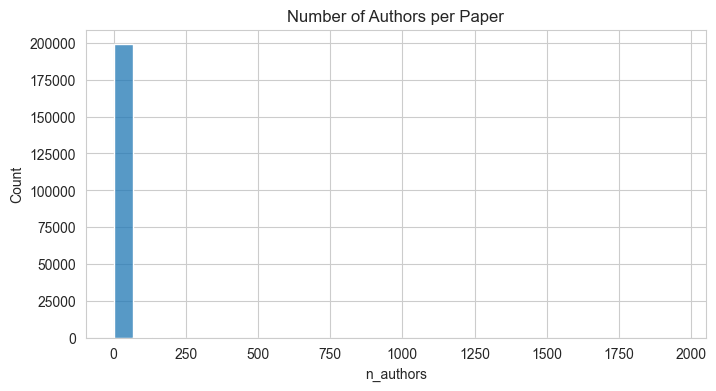

In [22]:
plt.figure(figsize=(8,4))
sns.histplot(df["n_authors"], bins=30)
plt.title("Number of Authors per Paper")
plt.show()

In [23]:
top10 = cat_df["category"].head(10)

cooc = pd.DataFrame(0, index=top10, columns=top10)

for cats in df["category_list"]:
    cats = set(cats).intersection(top10)
    for c1 in cats:
        for c2 in cats:
            if c1 != c2:
                cooc.loc[c1, c2] += 1

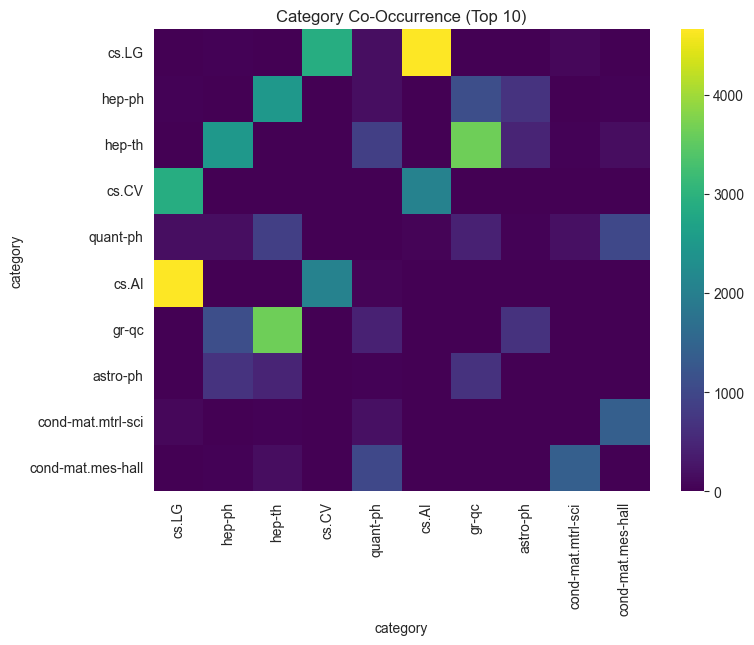

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(cooc, cmap="viridis")
plt.title("Category Co-Occurrence (Top 10)")
plt.show()

In [25]:
vectorizer = CountVectorizer(
    stop_words="english",
    max_features=20
)

X = vectorizer.fit_transform(df["abstract"].dropna().sample(50_000))

In [26]:
term_freq = pd.DataFrame({
    "term": vectorizer.get_feature_names_out(),
    "count": X.sum(axis=0).A1
}).sort_values("count", ascending=False)

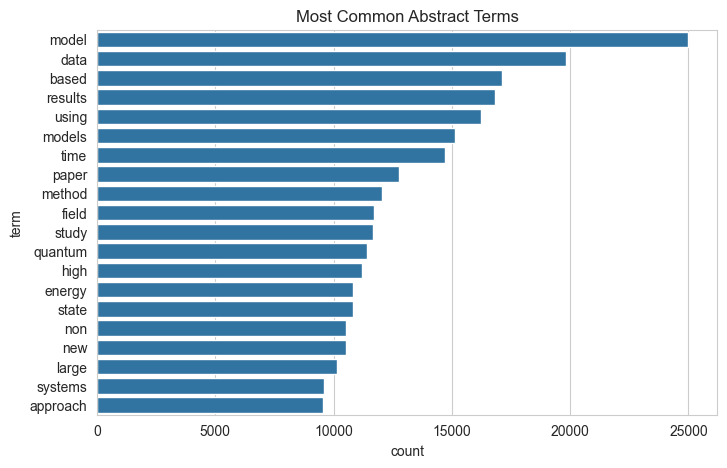

In [27]:
plt.figure(figsize=(8,5))
sns.barplot(data=term_freq, x="count", y="term")
plt.title("Most Common Abstract Terms")
plt.show()